In [ ]:
import numpy as np
import os
import glob
import torch
import nibabel as nib
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [ ]:

# Define the path to the training data folder
training_data_path = "Downloads/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Choose a patient (e.g., BraTS20_Training_001)
patient_folder = "BraTS20_Training_001"
patient_path = os.path.join(training_data_path, patient_folder)

# Load NIfTI files
flair_path = os.path.join(patient_path, f"{patient_folder}_flair.nii")
t1_path = os.path.join(patient_path, f"{patient_folder}_t1.nii")
t1ce_path = os.path.join(patient_path, f"{patient_folder}_t1ce.nii")
t2_path = os.path.join(patient_path, f"{patient_folder}_t2.nii")
seg_path = os.path.join(patient_path, f"{patient_folder}_seg.nii")

# Load NIfTI files
flair_img = nib.load(flair_path)
t1_img = nib.load(t1_path)
t1ce_img = nib.load(t1ce_path)
t2_img = nib.load(t2_path)
seg_img = nib.load(seg_path)

# Print shapes
print("FLAIR shape:", flair_img.shape)
print("T1 shape:", t1_img.shape)
print("T1 with contrast enhancement shape:", t1ce_img.shape)
print("T2 shape:", t2_img.shape)
print("Segmentation mask shape:", seg_img.shape)

FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1 with contrast enhancement shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation mask shape: (240, 240, 155)


In [ ]:
# Function to display the central slice along the Z-axis for multiple modalities
def plot_central_slices_z(patient_folder):
    # Define the path to the training data folder
    patient_path = os.path.join(training_data_path, patient_folder)

    # Load NIfTI files
    modalities = ["flair", "t1", "t1ce", "t2", "seg"]
    images = [nib.load(os.path.join(patient_path, f"{patient_folder}_{modality}.nii")).get_fdata() for modality in modalities]

    # Choose the central slice along the Z-axis
    central_slice = images[0].shape[2] // 2

    # Plot the central slice for each modality
    fig, axes = plt.subplots(1, len(modalities), figsize=(15, 5))

    for i, (modality, image) in enumerate(zip(modalities, images)):
        axes[i].imshow(image[:, :, central_slice], cmap="gray")
        axes[i].set_title(f"{modality.upper()}")

    plt.show()


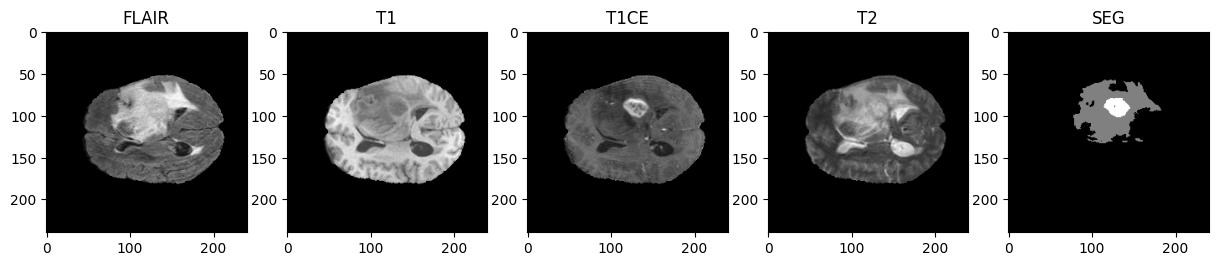

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_001"
plot_central_slices_z(patient_folder)

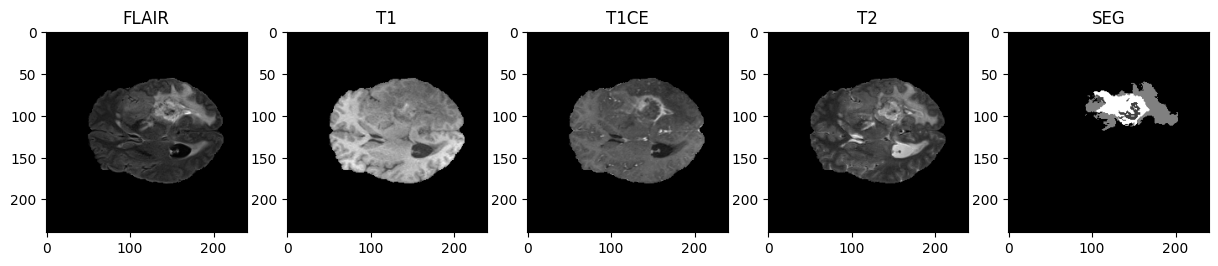

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_009"
plot_central_slices_z(patient_folder)

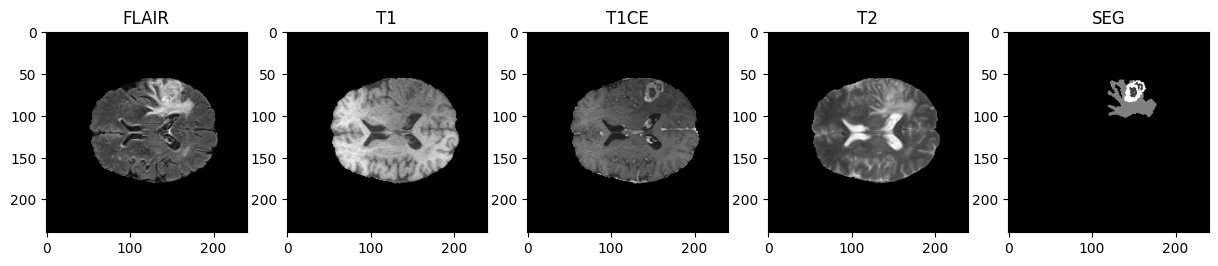

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_029"
plot_central_slices_z(patient_folder)

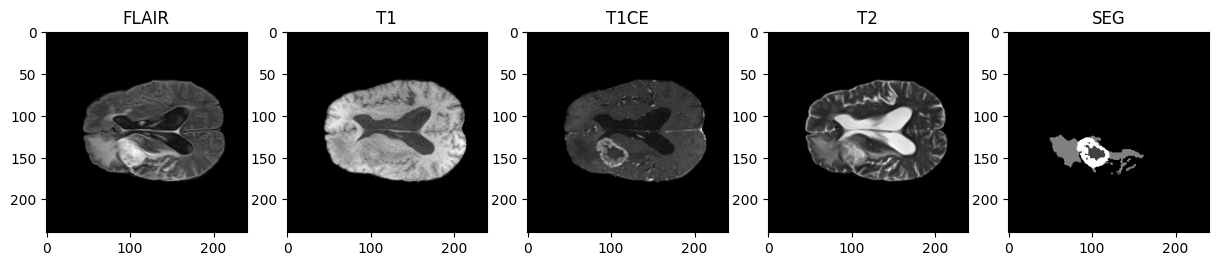

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_109"
plot_central_slices_z(patient_folder)

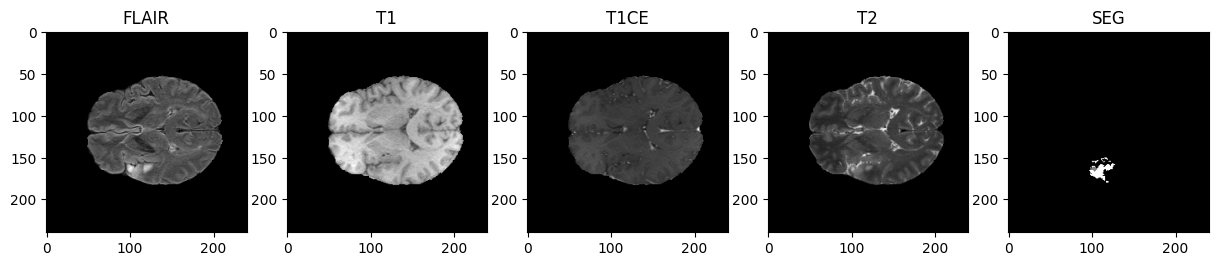

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_019"
plot_central_slices_z(patient_folder)

In [ ]:
# Update the paths
t1_list = sorted(glob.glob(os.path.join(training_data_path, '*/*t1.nii')))
t2_list = sorted(glob.glob(os.path.join(training_data_path, '*/*t2.nii')))
t1ce_list = sorted(glob.glob(os.path.join(training_data_path, '*/*t1ce.nii')))
flair_list = sorted(glob.glob(os.path.join(training_data_path, '*/*flair.nii')))
mask_list = sorted(glob.glob(os.path.join(training_data_path, '*/*seg.nii')))

In [ ]:
def extract_slices(t2_list, mask_list, output_folder):
    os.makedirs(os.path.join(output_folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'masks'), exist_ok=True)

    for t2_path, mask_path in zip(t2_list, mask_list):
        # Extract patient or image ID from the file path (you may need to adjust this based on your file structure)
        patient_id = os.path.basename(os.path.dirname(t2_path))

        # Load and preprocess the images
        t2_img = nib.load(t2_path).get_fdata()
        mask_img = nib.load(mask_path).get_fdata()
        mask_img[mask_img == 4] = 3

        # Ensure the dimensions match
        assert t2_img.shape == mask_img.shape, "Mismatched dimensions between T1CE and mask."

        # Iterate over slices along the z-axis
        for slice_idx in range(t2_img.shape[2]):
            t2_slice = t2_img[:, :, slice_idx]
            mask_slice = mask_img[:, :, slice_idx]

            # Save the slices as numpy files in separate folders with patient ID in the filename
            np.save(os.path.join(output_folder, 'images', f"t2_{patient_id}_{slice_idx}.npy"), t2_slice)
            np.save(os.path.join(output_folder, 'masks', f"mask_{patient_id}_{slice_idx}.npy"), mask_slice)

In [ ]:
#output_folder = "Downloads/Train_T2"
# Call the function
#extract_slices(t2_list, mask_list, output_folder)

In [ ]:
# Specify the paths to the image and mask folders
t2_images_folder = "Downloads/Train_T2/images"
masks_folder = "Downloads/Train_T2/masks"

# Count the number of images and masks
num_images = len(os.listdir(t2_images_folder))
num_masks = len(os.listdir(masks_folder))

# Print the counts
print("Number of images:", num_images)
print("Number of masks:", num_masks)

Number of images: 57195
Number of masks: 57195


In [ ]:
# Specify the paths to the image and mask folders
t1ce_images_folder = "Downloads/Train_T1CE/images"
masks_folder = "Downloads/Train_T1CE/masks"

# Count the number of images and masks
num_images = len(os.listdir(t1ce_images_folder))
num_masks = len(os.listdir(masks_folder))

# Print the counts
print("Number of images:", num_images)
print("Number of masks:", num_masks)

Number of images: 57195
Number of masks: 57195


In [ ]:
# Specify the paths to the image and mask folders
flair_images_folder = "Downloads/Train_Flair/images"
masks_folder = "Downloads/Train_Flair/masks"

# Count the number of images and masks
num_images = len(os.listdir(flair_images_folder))
num_masks = len(os.listdir(masks_folder))

# Print the counts
print("Number of images:", num_images)
print("Number of masks:", num_masks)

Number of images: 57195
Number of masks: 57195


In [ ]:
# Get the list of filenames in the T2 images folder
t2_images_filenames = os.listdir(t2_images_folder)
if t2_images_filenames:
    print("First T2 Image filename:", t2_images_filenames[0])

# Get the list of filenames in the masks folder
masks_filenames = os.listdir(masks_folder)
if masks_filenames:
    print("\nFirst Mask filename:", masks_filenames[0])


First T2 Image filename: t2_BraTS20_Training_059_55.npy

First Mask filename: mask_BraTS20_Training_086_45.npy


In [ ]:
# Get the list of filenames in the T2 images folder
t1ce_images_filenames = os.listdir(t1ce_images_folder)
if t2_images_filenames:
    print("First T1CE Image filename:", t1ce_images_filenames[0])

# Get the list of filenames in the masks folder
masks_filenames = os.listdir(masks_folder)
if masks_filenames:
    print("\nFirst Mask filename:", masks_filenames[0])


First T1CE Image filename: t1ce_BraTS20_Training_225_133.npy

First Mask filename: mask_BraTS20_Training_086_45.npy


In [ ]:
# Get the list of filenames in the T2 images folder
flair_images_filenames = os.listdir(flair_images_folder)
if t2_images_filenames:
    print("First Flair Image filename:", flair_images_filenames[0])

# Get the list of filenames in the masks folder
masks_filenames = os.listdir(masks_folder)
if masks_filenames:
    print("\nFirst Mask filename:", masks_filenames[0])


First Flair Image filename: flair_BraTS20_Training_228_134.npy

First Mask filename: mask_BraTS20_Training_086_45.npy


In [ ]:
def merge_modalities(t2_images_folder, t1ce_images_folder, flair_images_folder, merged_images_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(merged_images_folder):
        os.makedirs(merged_images_folder)

    # Get the list of image files in the T2 folder
    t2_filenames = os.listdir(t2_images_folder)

    for t2_filename in t2_filenames:
        # Construct paths for T1CE and Flair images based on the T2 image filename
        t1ce_filename = t2_filename.replace('t2_', 't1ce_')
        flair_filename = t2_filename.replace('t2_', 'flair_')

        t2_path = os.path.join(t2_images_folder, t2_filename)
        t1ce_path = os.path.join(t1ce_images_folder, t1ce_filename)
        flair_path = os.path.join(flair_images_folder, flair_filename)

        # Load images
        t2_image = np.load(t2_path)
        t1ce_image = np.load(t1ce_path)
        flair_image = np.load(flair_path)

        # Concatenate along the channel dimension
        merged_image = np.stack([t2_image, t1ce_image, flair_image], axis=-1)

        # Save the merged image to the output folder
        output_filename = t2_filename.replace('t2_', 'all_')  # Replace 't2_' prefix with 'all_'
        output_path = os.path.join(merged_images_folder, output_filename)
        #print(flair_image.shape, merged_image.shape)
        np.save(output_path, merged_image)

    print("Merging completed.")


In [ ]:
t2_images_folder = "Downloads/Train_T2/images"
t1ce_images_folder = "Downloads/Train_T1CE/images"
flair_images_folder = "Downloads/Train_Flair/images"
merged_images_folder = "Downloads/Train_All/images"

merge_modalities(t2_images_folder, t1ce_images_folder, flair_images_folder, merged_images_folder)

Merging completed.


In [ ]:
# Specify the paths to the image and mask folders
merged_images_folder = "Downloads/Train_All/images"
masks_folder = "Downloads/Train_All/masks"

# Count the number of images and masks
num_images = len(os.listdir(merged_images_folder))
num_masks = len(os.listdir(masks_folder))

# Print the counts
print("Number of images:", num_images)
print("Number of masks:", num_masks)

Number of images: 57195
Number of masks: 57195


In [ ]:
# Get the path of the first image and mask
first_image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[0])
first_mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[0].replace('all','mask'))

print(first_image_path)
print(first_mask_path)

first_image = np.load(first_image_path)
first_mask = np.load(first_mask_path)


# Print the sizes
print("Size of the first image:", first_image.shape)
print("Size of the first mask:", first_mask.shape)

Downloads/Train_All/images/all_BraTS20_Training_258_57.npy
Downloads/Train_All/masks/mask_BraTS20_Training_258_57.npy
Size of the first image: (240, 240, 3)
Size of the first mask: (240, 240)


In [ ]:
def show_channels_and_mask(image_path, mask_path):
    # Load MRI image
    image = np.load(image_path)

    # Load mask
    mask = np.load(mask_path)

    # Plot each channel of the MRI image
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    channels = ['T2', 'T1CE', 'Flair', 'Mask']

    for i in range(3):
        axes[i].imshow(image[:, :, i], cmap='gray')
        axes[i].set_title(channels[i])
        axes[i].axis('off')

    plt.imshow(mask, cmap='viridis')  # Assuming binary mask, adjust cmap as needed
    axes[3].set_title(channels[3])
    axes[3].axis('off')

    plt.show()


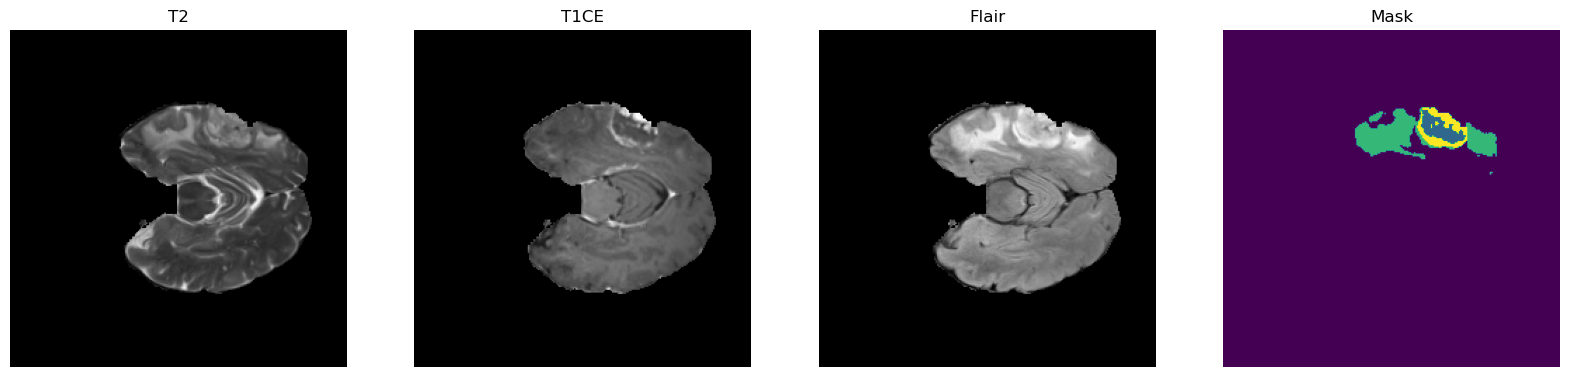

In [ ]:
# Example usage:

image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[88])
mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[88].replace('all','mask'))

show_channels_and_mask(image_path, mask_path)

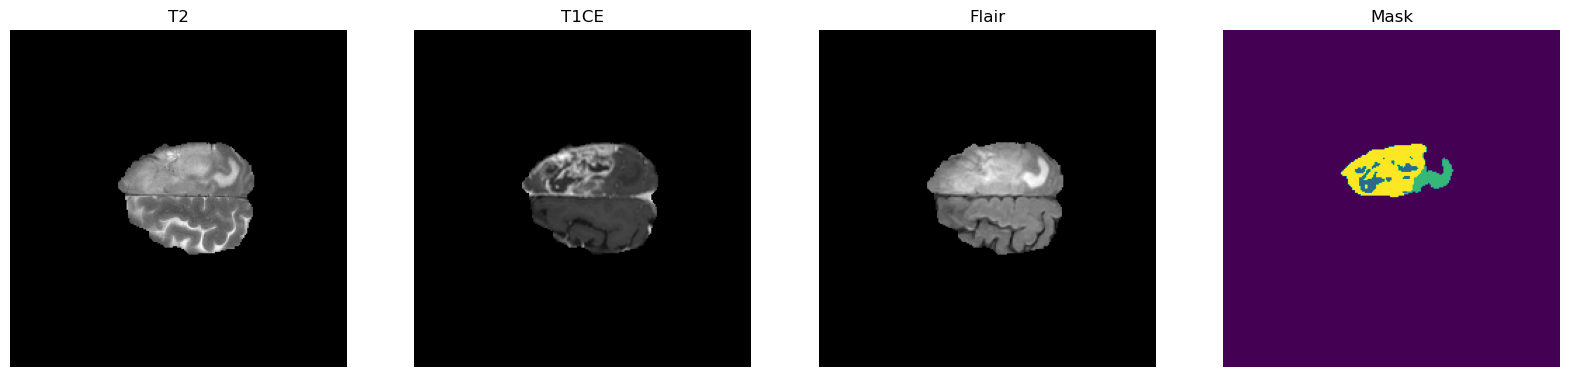

In [ ]:
# Example usage:

image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[188])
mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[188].replace('all','mask'))

show_channels_and_mask(image_path, mask_path)

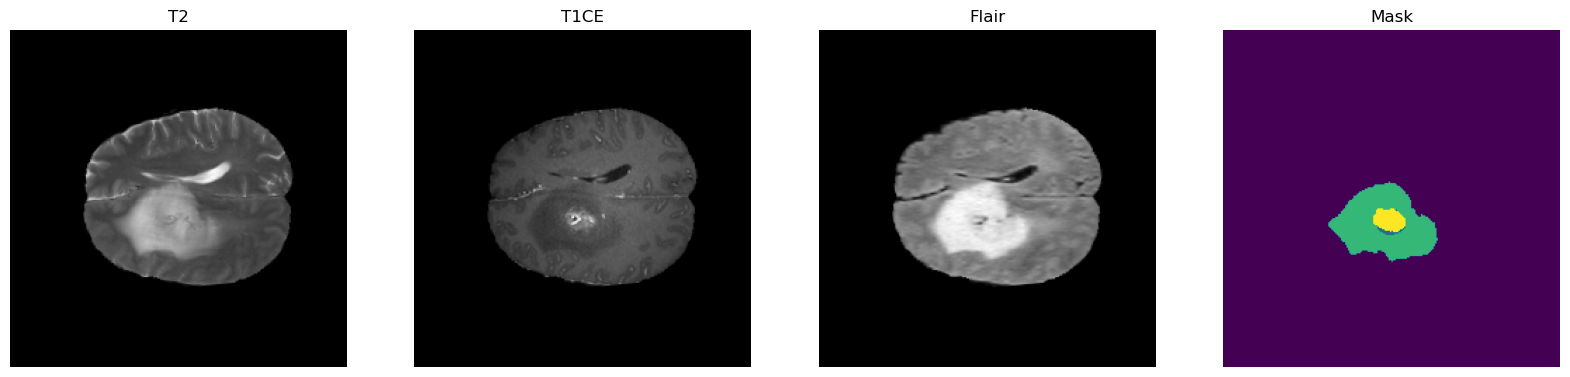

In [ ]:
# Example usage:

image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[8888])
mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[8888].replace('all','mask'))

show_channels_and_mask(image_path, mask_path)

In [ ]:
def show_channels_and_masks_separately(image_path, mask_path):
    # Load MRI image
    image = np.load(image_path)

    # Load mask
    mask = np.load(mask_path)

    # Plot each channel of the MRI image
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    channels = ['T2', 'T1CE', 'Flair', 'Class 1', 'Class 2', 'Class 3']

    for i in range(3):
        axes[0,i].imshow(image[:, :, i], cmap='gray')
        axes[0,i].set_title(channels[i])
        axes[0,i].axis('off')

    mask = torch.from_numpy(mask).long()  # Convert to a long tensor
    mask = torch.nn.functional.one_hot(mask, 4)

    axes[1,0].imshow(mask[:, :, 1], cmap='gray')  # Assuming binary mask, adjust cmap as needed
    axes[1,0].set_title(channels[3])
    axes[1,0].axis('off')
    axes[1,1].imshow(mask[:, :, 3], cmap='gray')  # Assuming binary mask, adjust cmap as needed
    axes[1,1].set_title(channels[4])
    axes[1,1].axis('off')
    axes[1,2].imshow(mask[:, :, 2], cmap='gray')  # Assuming binary mask, adjust cmap as needed
    axes[1,2].set_title(channels[5])
    axes[1,2].axis('off')

    plt.show()


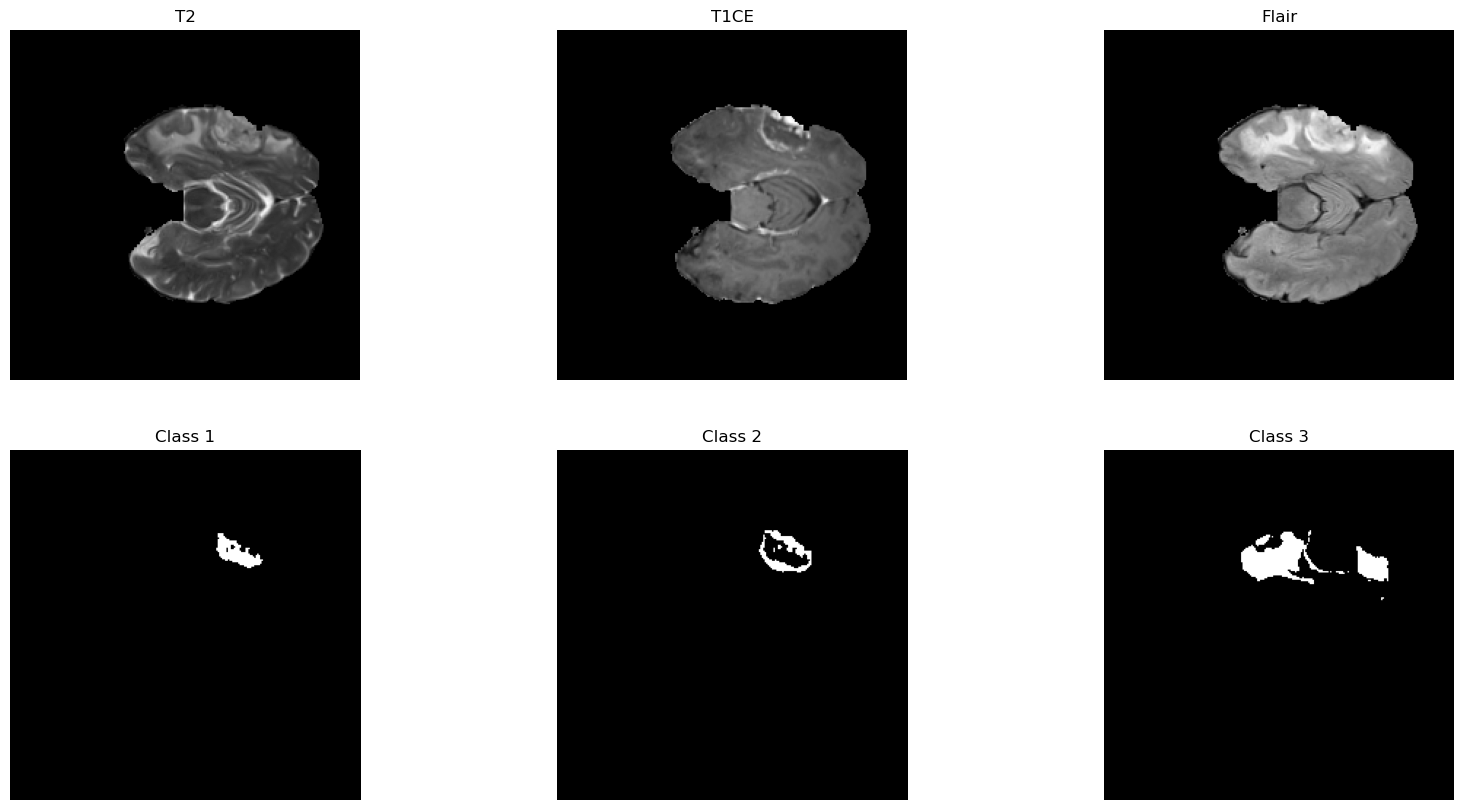

In [ ]:
# Example usage:

image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[88])
mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[88].replace('all','mask'))

show_channels_and_masks_separately(image_path, mask_path)

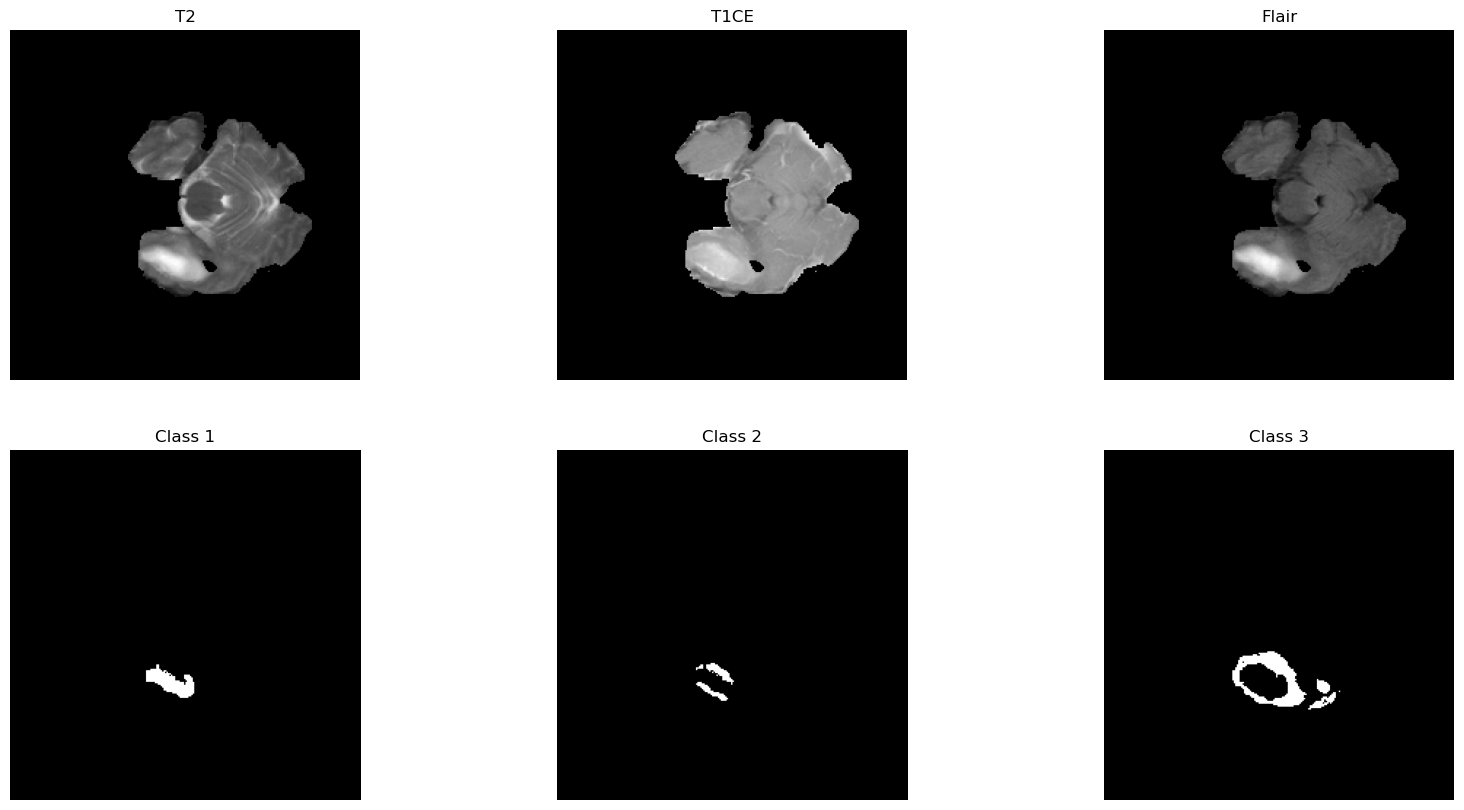

In [ ]:
# Example usage:

image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[19901])
mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[19901].replace('all','mask'))

show_channels_and_masks_separately(image_path, mask_path)

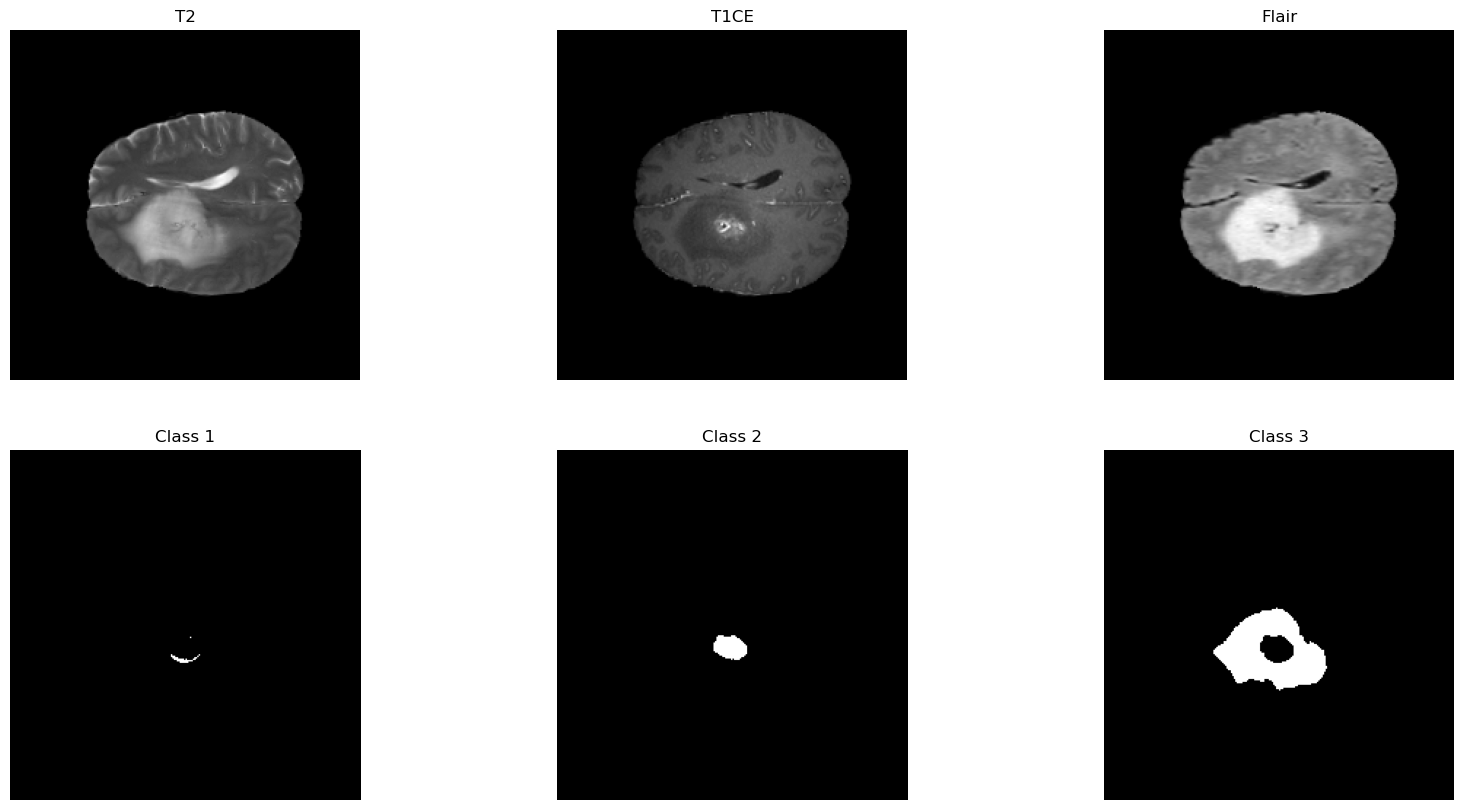

In [ ]:
# Example usage:

image_path = os.path.join(merged_images_folder, os.listdir(merged_images_folder)[8888])
mask_path = os.path.join(masks_folder, os.listdir(merged_images_folder)[8888].replace('all','mask'))

show_channels_and_masks_separately(image_path, mask_path)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        x= self.final_conv(x)
        x= F.softmax(x, dim=1)
        return x

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1e-5
        print(logits.shape, logits)
        # Flatten the logits and targets
        logits_flat = logits.view(-1)
        targets_flat = targets.view(-1)

        intersection = (logits_flat * targets_flat).sum()
        union = logits_flat.sum() + targets_flat.sum()

        dice_coefficient = (2. * intersection + smooth) / (union + smooth)

        dice_loss = 1 - dice_coefficient

        return dice_loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4):  # Adjust num_classes based on your task
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes

    def forward(self, logits, targets):
        smooth = 1e-5

        # Initialize loss to zero
        dice_loss = 0.0

        for class_index in range(self.num_classes):
            # Extract logits and targets for the current class
            #print(logits.shape, logits)
            logits_class = logits[:, class_index, :, :].reshape(-1)
            targets_class = targets[:,class_index,:,:].reshape(-1)

            # Calculate intersection and union for the current class
            intersection = (logits_class * targets_class).sum()
            union = logits_class.sum() + targets_class.sum()

            # Calculate Dice coefficient for the current class
            dice_coefficient = (2. * intersection + smooth) / (union + smooth)

            # Add the Dice coefficient to the overall loss
            dice_loss += 1 - dice_coefficient

        # Average the Dice loss over all classes
        dice_loss /= self.num_classes

        return dice_loss

In [ ]:
import torch

# Create dummy input and target
logits = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]])  # Example logits (replace with your own)
targets = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]])  # Example targets (replace with your own)

# Instantiate DiceLoss
dice_loss = DiceLoss()

# Forward pass
loss = dice_loss(logits, targets)

print(f"Dice Loss for perfect overlap: {loss.item()}")

Dice Loss for perfect overlap: 0.0


In [ ]:
# Create dummy input and target with no overlap
logits_no_overlap = torch.tensor([[[[0.0, 0.0], [0.0, 0.0]]]])
targets_no_overlap = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]])

# Forward pass
loss_no_overlap = dice_loss(logits_no_overlap, targets_no_overlap)

print(f"Dice Loss for no overlap: {loss_no_overlap.item()}")

Dice Loss for no overlap: 0.9999974966049194


In [ ]:
# Create dummy one-hot encoded ground truth and predicted values
ground_truth = torch.tensor([[[[0, 1], [1, 0]]]])  # Example one-hot encoded ground truth
predicted_values = torch.tensor([[[[0.2, 0.8], [0.6, 0.4]]]])  # Example predicted values (after softmax)

# Forward pass
loss_segmentation = dice_loss(predicted_values, ground_truth)

print(f"Dice Loss for segmentation example: {loss_segmentation.item()}")


Dice Loss for segmentation example: 0.2999991774559021


In [ ]:
model = UNET(in_channels=3, out_channels=4)

In [ ]:
model.eval()
x = torch.randn((2, 3, 240, 240))
save=x
with torch.no_grad():
    y = model(x)
print(x.shape,y.shape,y[0,0,0,0],y[0,1,0,0],y[0,2,0,0],y[0,3,0,0])

torch.Size([2, 3, 240, 240]) torch.Size([2, 4, 240, 240]) tensor(0.2842) tensor(0.2377) tensor(0.2416) tensor(0.2365)


In [ ]:
with torch.no_grad():
    y = model(save)
print(save.shape,y.shape,y[0,0,0,0],y[0,1,0,0],y[0,2,0,0],y[0,3,0,0])

torch.Size([2, 3, 240, 240]) torch.Size([2, 4, 240, 240]) tensor(0.2842) tensor(0.2377) tensor(0.2416) tensor(0.2365)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, masks_folder, transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.transform = transform

        self.image_files = sorted(os.listdir(images_folder))
        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = np.load(image_path)
        mask = np.load(mask_path)

        # Apply transformations if provided
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, masks_folder, image_list=None, transform=None):
        self.images_folder = images_folder
        self.image_list = image_list
        self.masks_folder = masks_folder
        self.transform = transform

        if image_list is not None:
            self.image_files = sorted(image_list)
        else:
            self.image_files = sorted(os.listdir(images_folder))

        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.image_files[idx].replace('all','mask'))

        image = np.load(image_path)
        mask = np.load(mask_path)

        # Apply transformations if provided
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

In [ ]:
class ToTensor(object):
    def __call__(self, image, mask):
        # Convert to PyTorch tensors
        image = transforms.ToTensor()(image)

        # Center crop to size 128x128
        center_crop = transforms.CenterCrop((144, 144))
        image = center_crop(image)

        # Min-max normalization
        min_val = image.min()
        max_val = image.max()
        epsilon = 1e-6
        normalised_image = (image - min_val) / max((max_val - min_val), epsilon)

        # Convert segmentation mask to one-hot encoding

        num_classes = 4  # Background + 3 classes
        mask_index = torch.from_numpy(mask).long()  # Convert to a long tensor
        mask_index = center_crop(mask_index)  # Apply center crop to the mask
        mask_one_hot = torch.nn.functional.one_hot(mask_index, num_classes).permute(2, 0, 1)

        return normalised_image, mask_one_hot

In [ ]:
# Get the list of filenames in the images folder
image_files = sorted(os.listdir(merged_images_folder))

# Perform train-test split
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Create datasets for training and validation
train_dataset = CustomDataset(images_folder=merged_images_folder, masks_folder=masks_folder, image_list=train_files, transform=ToTensor())
val_dataset = CustomDataset(images_folder=merged_images_folder, masks_folder=masks_folder, image_list=val_files, transform=ToTensor())

# Specify batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
# Get the size of the train and validation loaders
train_loader_size = len(train_loader.dataset)
val_loader_size = len(val_loader.dataset)

print("Size of Train Loader:", train_loader_size)
print("Size of Validation Loader:", val_loader_size)

# Get the shape of elements in the loaders
sample_train_data = next(iter(train_loader))
sample_val_data = next(iter(val_loader))
sample_train_image, sample_train_mask = sample_train_data
sample_val_image, sample_val_mask = sample_val_data

print("Shape of Sample Train Image:", sample_train_image.shape)
print("Shape of Sample Train Mask:", sample_train_mask.shape)
print("Shape of Sample Validation Image:", sample_val_image.shape)
print("Shape of Sample Validation Mask:", sample_val_mask.shape)

Size of Train Loader: 45756
Size of Validation Loader: 11439
Shape of Sample Train Image: torch.Size([64, 3, 144, 144])
Shape of Sample Train Mask: torch.Size([64, 4, 144, 144])
Shape of Sample Validation Image: torch.Size([64, 3, 144, 144])
Shape of Sample Validation Mask: torch.Size([64, 4, 144, 144])


  Images:
    Shape: torch.Size([64, 3, 144, 144])
    Type: torch.float64
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


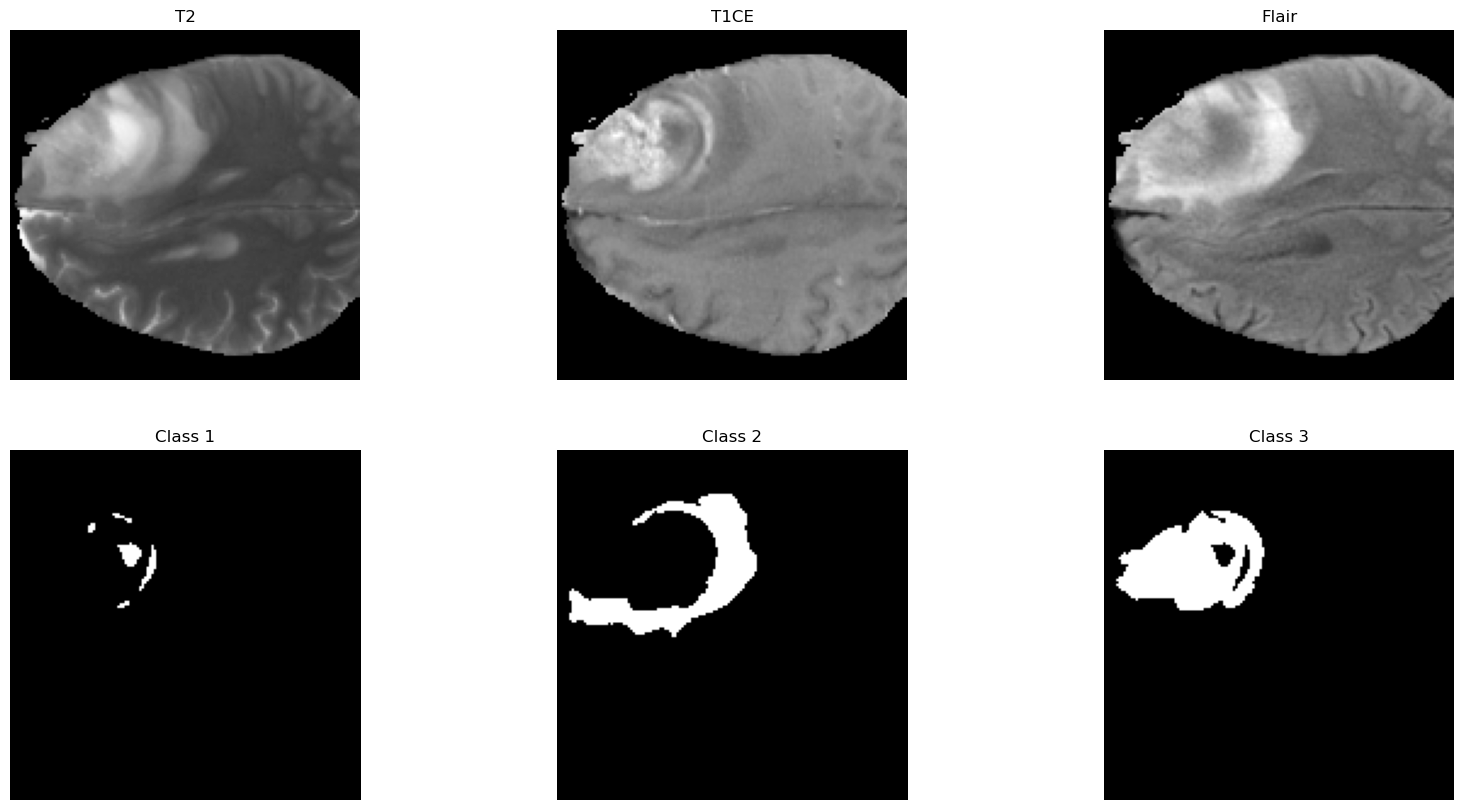

In [ ]:
for batch_idx, (images, masks) in enumerate(train_loader):

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")

    # Plot each channel of the MRI image
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    channels = ['T2', 'T1CE', 'Flair', 'Class 1', 'Class 2', 'Class 3']

    for i in range(3):
        axes[0,i].imshow(images[0][i, :, :], cmap='gray')
        axes[0,i].set_title(channels[i])
        axes[0,i].axis('off')

    for i in range(3):
        axes[1,i].imshow(masks[0][1+i, :, :], cmap='gray')
        axes[1,i].set_title(channels[3+i])
        axes[1,i].axis('off')


    plt.show()
    break

  Images:
    Shape: torch.Size([32, 3, 144, 144])
    Type: torch.float64
  Masks:
    Shape: torch.Size([32, 4, 144, 144])
    Type: torch.int64


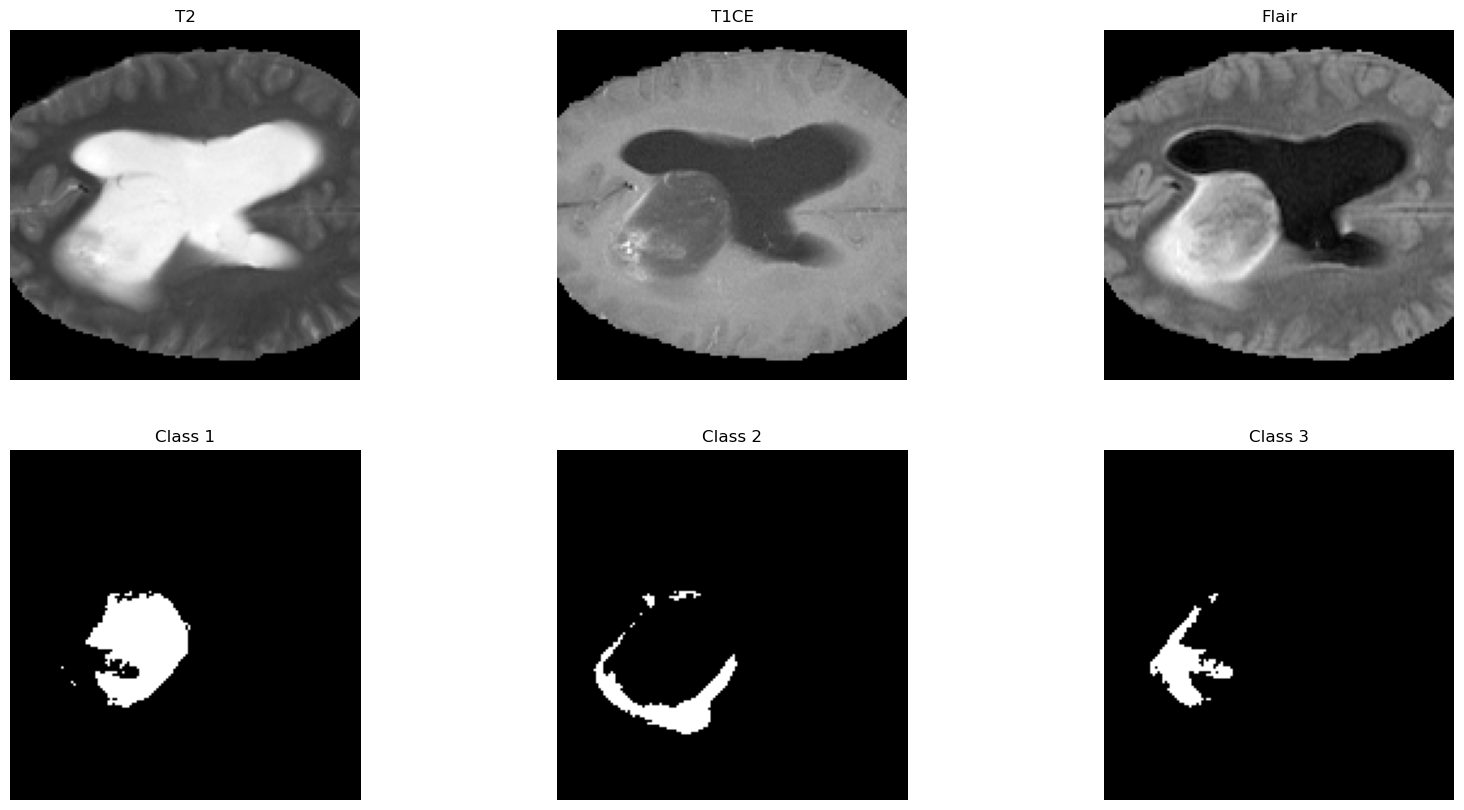

In [ ]:
for batch_idx, (images, masks) in enumerate(train_loader):

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")

    # Plot each channel of the MRI image
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    channels = ['T2', 'T1CE', 'Flair', 'Class 1', 'Class 2', 'Class 3']

    for i in range(3):
        axes[0,i].imshow(images[0][i, :, :], cmap='gray')
        axes[0,i].set_title(channels[i])
        axes[0,i].axis('off')

    for i in range(3):
        axes[1,i].imshow(masks[0][1+i, :, :], cmap='gray')
        axes[1,i].set_title(channels[3+i])
        axes[1,i].axis('off')


    plt.show()
    break

Model Prediction Shape torch.Size([32, 4, 144, 144])
Argmax Shape torch.Size([32, 1, 144, 144])
One Hot Shape torch.Size([32, 4, 144, 144])


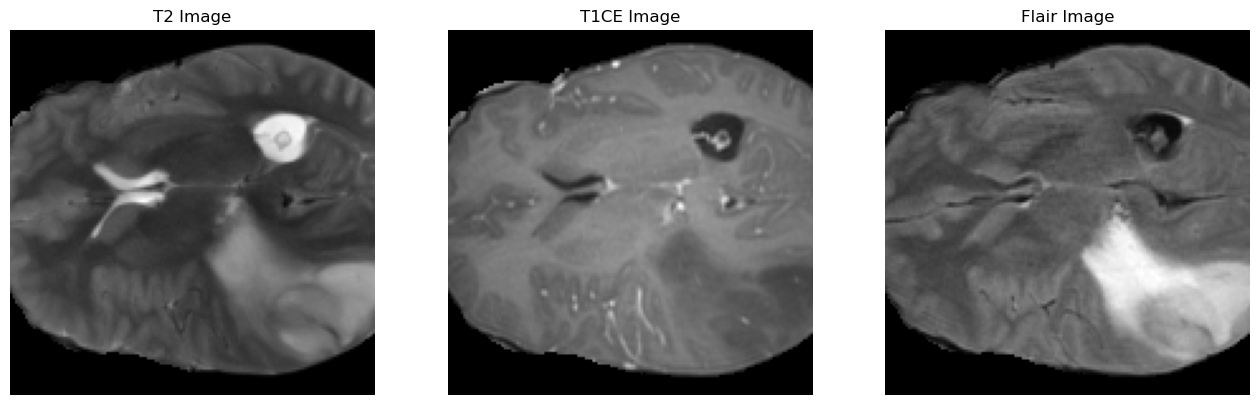

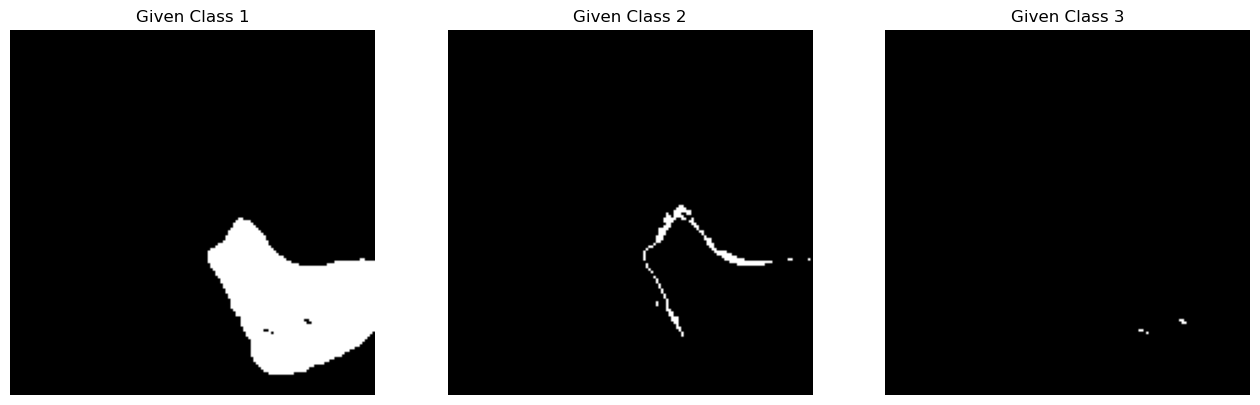

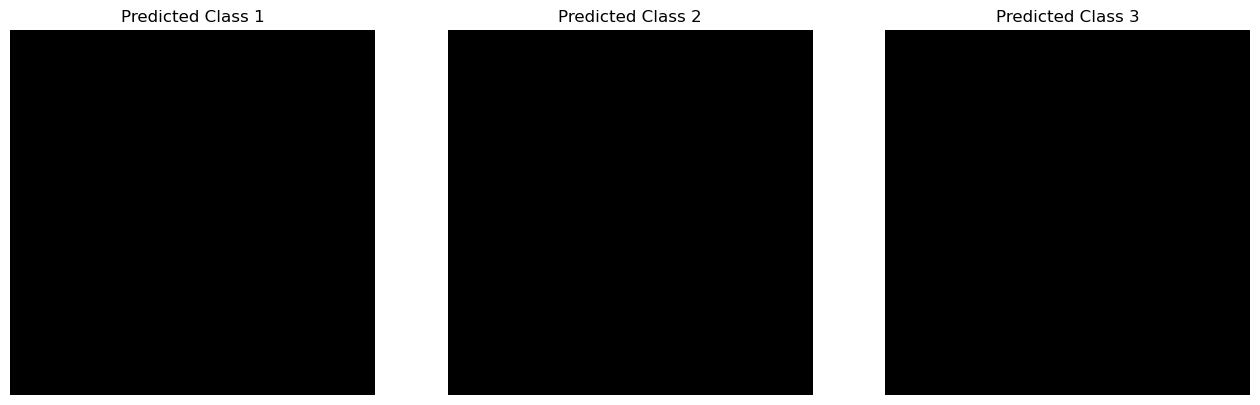

In [ ]:
for batch_idx, (images, masks) in enumerate(train_loader):

    model.eval()
    with torch.no_grad():
      # Forward pass
      images = images.float()
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)

      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(images[0, 0], cmap='gray')
    plt.title('T2 Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(images[0, 1], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(images[0, 2], cmap='gray')
    plt.title('Flair Image')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(masks[0, 1], cmap='gray')
    plt.title('Given Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(masks[0, 2], cmap='gray')
    plt.title('Given Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(masks[0, 3], cmap='gray')
    plt.title('Given Class 3')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(preds[0, 1], cmap='gray')
    plt.title('Predicted Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(preds[0, 2], cmap='gray')
    plt.title('Predicted Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(preds[0, 3], cmap='gray')
    plt.title('Predicted Class 3')
    plt.axis('off')

    plt.show()

    break


In [ ]:
dice_loss = DiceLoss()
# Define optimizer, device, etc.
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
model = model.to(device)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    total_loss = 0.0

    # Use tqdm for progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training")

    for batch_idx, (images, masks) in pbar:
        # Move data to the device
        images, masks = images.to(device), masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        images = images.float()

        # Forward pass
        outputs = model(images)

        # Calculate the Dice Loss
        loss = dice_loss(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the total loss for printing
        total_loss += loss.item()

        # Update tqdm progress bar
        pbar.set_postfix({"Dice Loss": loss.item()})

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"Average Training Dice Loss: {average_loss:.4f}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0

    # Use tqdm for progress bar
    val_pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Validation")

    with torch.no_grad():
        for batch_idx, (val_images, val_masks) in val_pbar:
            # Move data to the device
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_images = val_images.float()

            # Forward pass
            val_outputs = model(val_images)

            # Calculate the Dice Loss for validation
            val_loss = dice_loss(val_outputs, val_masks)

            # Accumulate the total validation loss for printing
            total_val_loss += val_loss.item()

            # Update tqdm progress bar
            val_pbar.set_postfix({"Dice Loss": val_loss.item()})

    # Print average validation loss for the epoch
    average_val_loss = total_val_loss / len(val_loader)
    print(f"Average Validation Dice Loss: {average_val_loss:.4f}")

# Optionally, save the trained model
torch.save(model.state_dict(), "unet_all3_144_0.pth")

Epoch 1/10 - Training: 100%|█| 715/715 [35:32<00:00,  2.98s/it, Dice Loss=0.166]

Average Training Dice Loss: 0.1611



Epoch 1/10 - Validation: 100%|█| 179/179 [09:33<00:00,  3.21s/it, Dice Loss=0.08

Average Validation Dice Loss: 0.1981



Epoch 2/10 - Training: 100%|█| 715/715 [37:11<00:00,  3.12s/it, Dice Loss=0.127]

Average Training Dice Loss: 0.1503



Epoch 2/10 - Validation: 100%|█| 179/179 [08:56<00:00,  2.99s/it, Dice Loss=0.10

Average Validation Dice Loss: 0.1871



Epoch 3/10 - Training: 100%|█| 715/715 [34:37<00:00,  2.91s/it, Dice Loss=0.169]

Average Training Dice Loss: 0.1407



Epoch 3/10 - Validation: 100%|█| 179/179 [08:39<00:00,  2.90s/it, Dice Loss=0.09

Average Validation Dice Loss: 0.1730



Epoch 4/10 - Training: 100%|█| 715/715 [34:24<00:00,  2.89s/it, Dice Loss=0.115]

Average Training Dice Loss: 0.1314



Epoch 4/10 - Validation: 100%|█| 179/179 [08:41<00:00,  2.92s/it, Dice Loss=0.06

Average Validation Dice Loss: 0.1598



Epoch 5/10 - Training: 100%|█| 715/715 [34:23<00:00,  2.89s/it, Dice Loss=0.123]

Average Training Dice Loss: 0.1236



Epoch 5/10 - Validation: 100%|█| 179/179 [08:40<00:00,  2.91s/it, Dice Loss=0.06

Average Validation Dice Loss: 0.1528



Epoch 6/10 - Training: 100%|█| 715/715 [34:35<00:00,  2.90s/it, Dice Loss=0.139]

Average Training Dice Loss: 0.1163



Epoch 6/10 - Validation: 100%|█| 179/179 [08:43<00:00,  2.93s/it, Dice Loss=0.06

Average Validation Dice Loss: 0.1459



Epoch 7/10 - Training: 100%|█| 715/715 [34:30<00:00,  2.90s/it, Dice Loss=0.104]

Average Training Dice Loss: 0.1122



Epoch 7/10 - Validation: 100%|█| 179/179 [08:43<00:00,  2.92s/it, Dice Loss=0.07

Average Validation Dice Loss: 0.1415



Epoch 8/10 - Training: 100%|█| 715/715 [34:32<00:00,  2.90s/it, Dice Loss=0.104]

Average Training Dice Loss: 0.1068



Epoch 8/10 - Validation: 100%|█| 179/179 [08:41<00:00,  2.91s/it, Dice Loss=0.07

Average Validation Dice Loss: 0.1634



Epoch 9/10 - Training: 100%|█| 715/715 [34:34<00:00,  2.90s/it, Dice Loss=0.0854

Average Training Dice Loss: 0.1037



Epoch 9/10 - Validation: 100%|█| 179/179 [08:43<00:00,  2.93s/it, Dice Loss=0.07

Average Validation Dice Loss: 0.1410



Epoch 10/10 - Training: 100%|█| 715/715 [34:30<00:00,  2.90s/it, Dice Loss=0.073

Average Training Dice Loss: 0.0959



Epoch 10/10 - Validation: 100%|█| 179/179 [08:49<00:00,  2.96s/it, Dice Loss=0.0


Average Validation Dice Loss: 0.1293


Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])


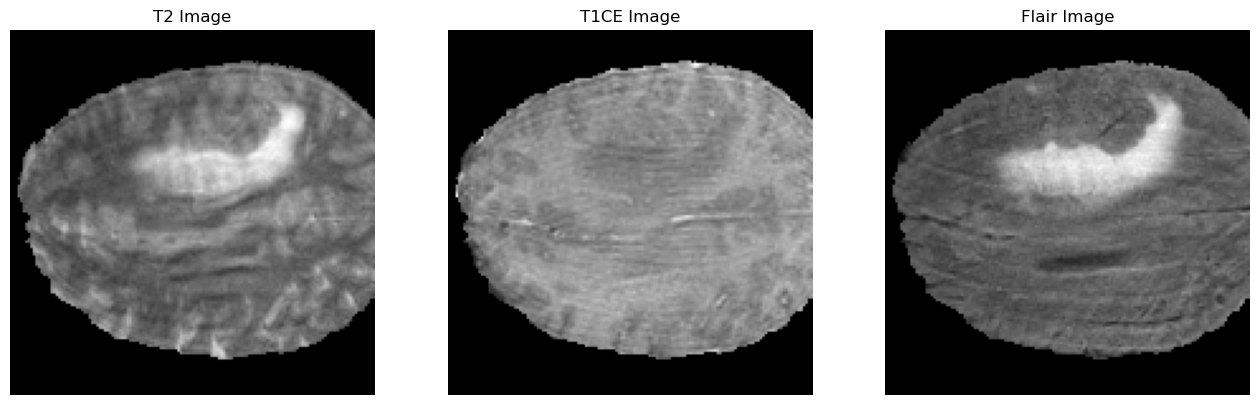

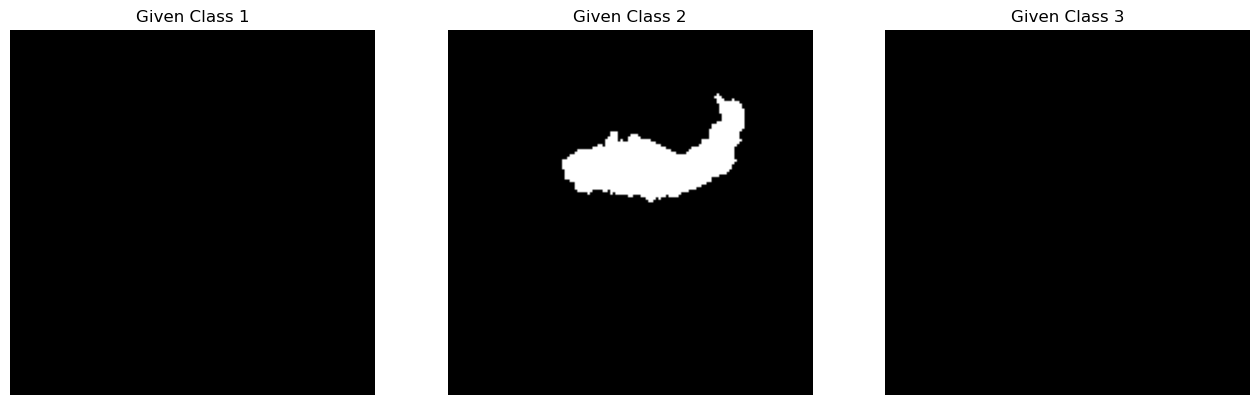

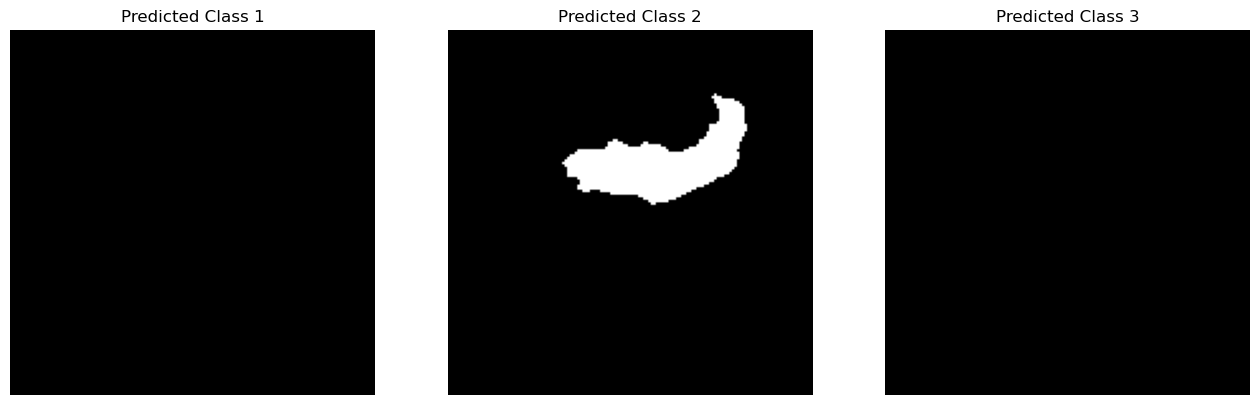

In [ ]:
for batch_idx, (images, masks) in enumerate(val_loader):
    images = images.to(device)
    #masks = masks.to(device)
    model.eval()
    with torch.no_grad():
      # Forward pass
      images = images.float()
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)

      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T2 Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(images.cpu()[0, 1], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(images.cpu()[0, 2], cmap='gray')
    plt.title('Flair Image')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(masks[0, 1], cmap='gray')
    plt.title('Given Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(masks[0, 2], cmap='gray')
    plt.title('Given Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(masks[0, 3], cmap='gray')
    plt.title('Given Class 3')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(preds.cpu()[0, 1], cmap='gray')
    plt.title('Predicted Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(preds.cpu()[0, 2], cmap='gray')
    plt.title('Predicted Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(preds.cpu()[0, 3], cmap='gray')
    plt.title('Predicted Class 3')
    plt.axis('off')

    plt.show()

    break


Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])


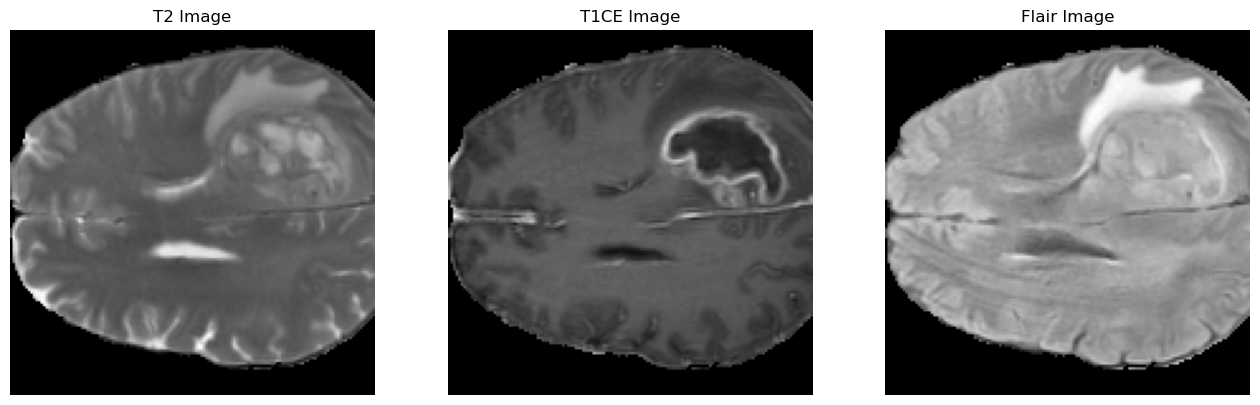

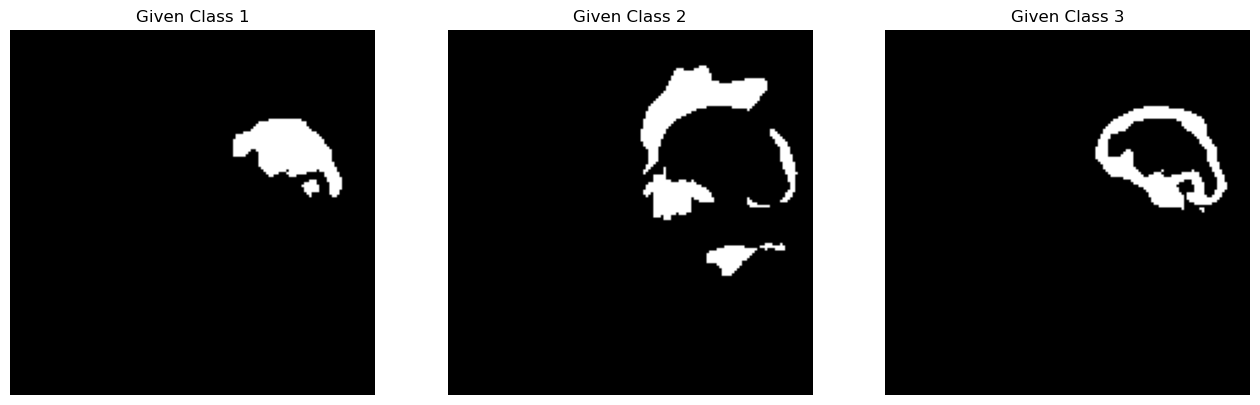

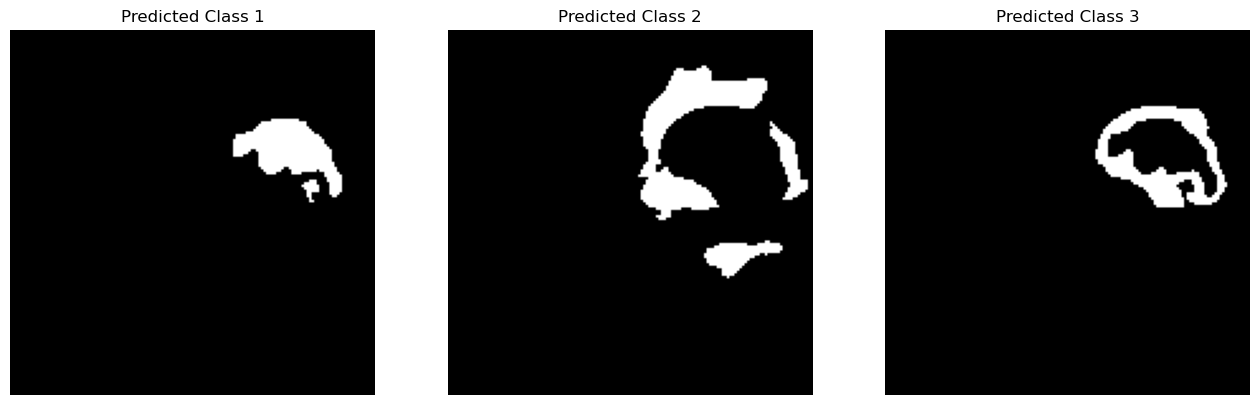

In [ ]:
for batch_idx, (images, masks) in enumerate(val_loader):
    images = images.to(device)
    #masks = masks.to(device)
    model.eval()
    with torch.no_grad():
      # Forward pass
      images = images.float()
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)

      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T2 Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(images.cpu()[0, 1], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(images.cpu()[0, 2], cmap='gray')
    plt.title('Flair Image')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(masks[0, 1], cmap='gray')
    plt.title('Given Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(masks[0, 2], cmap='gray')
    plt.title('Given Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(masks[0, 3], cmap='gray')
    plt.title('Given Class 3')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(preds.cpu()[0, 1], cmap='gray')
    plt.title('Predicted Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(preds.cpu()[0, 2], cmap='gray')
    plt.title('Predicted Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(preds.cpu()[0, 3], cmap='gray')
    plt.title('Predicted Class 3')
    plt.axis('off')

    plt.show()

    break


Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])


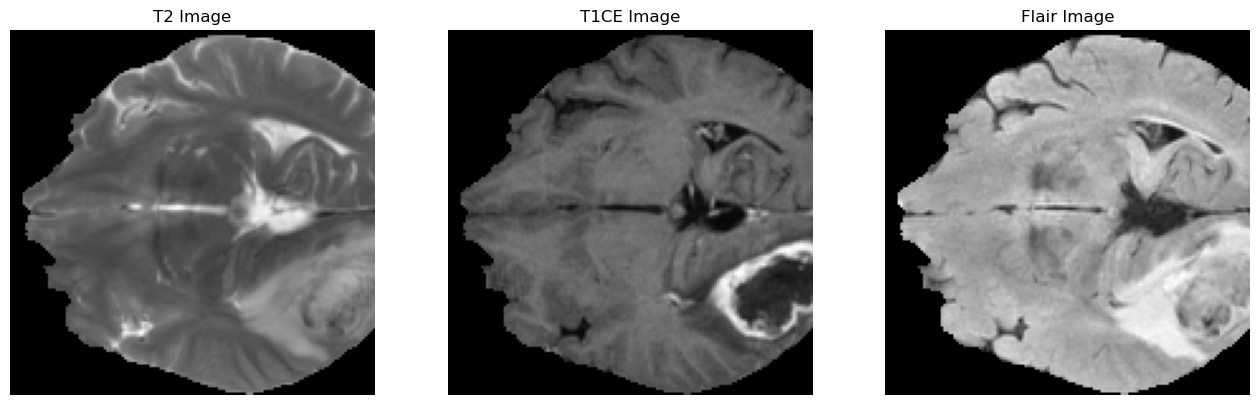

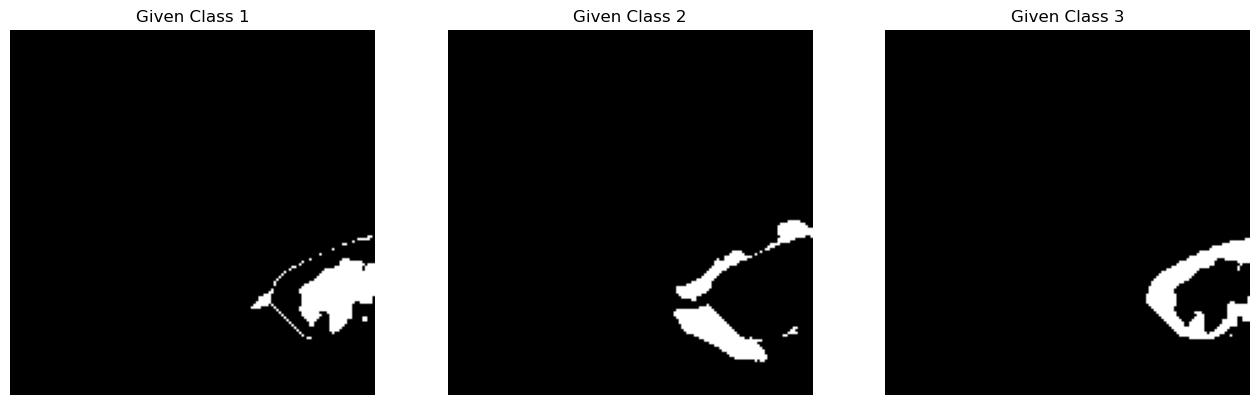

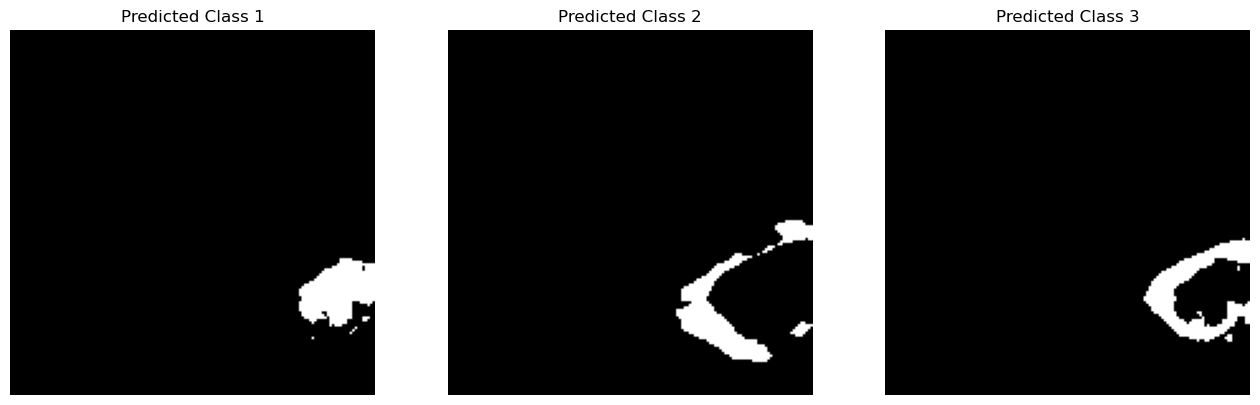

In [ ]:
for batch_idx, (images, masks) in enumerate(val_loader):
    images = images.to(device)
    #masks = masks.to(device)
    model.eval()
    with torch.no_grad():
      # Forward pass
      images = images.float()
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)

      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T2 Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(images.cpu()[0, 1], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(images.cpu()[0, 2], cmap='gray')
    plt.title('Flair Image')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(masks[0, 1], cmap='gray')
    plt.title('Given Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(masks[0, 2], cmap='gray')
    plt.title('Given Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(masks[0, 3], cmap='gray')
    plt.title('Given Class 3')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 3, 1)
    plt.imshow(preds.cpu()[0, 1], cmap='gray')
    plt.title('Predicted Class 1')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 2)
    plt.imshow(preds.cpu()[0, 2], cmap='gray')
    plt.title('Predicted Class 2')
    plt.axis('off')

    # Plot the first image
    plt.subplot(1, 3, 3)
    plt.imshow(preds.cpu()[0, 3], cmap='gray')
    plt.title('Predicted Class 3')
    plt.axis('off')

    plt.show()

    break
